In [2]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [3]:
train= datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]),)
test = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor(),]),)

100%|██████████| 9912422/9912422 [00:00<00:00, 24043960.95it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 9634589.50it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5797647.03it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(),dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

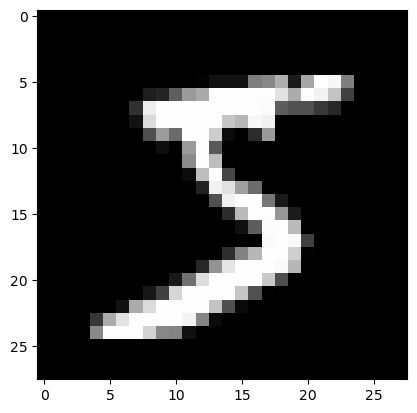

In [5]:
plot(train.data[0])

In [6]:
x = train.data.float() / 255.
y = train.targets

x= x.view(x.size(0), -1)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [7]:
input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

input_size: 784, output_size: 10


In [8]:
ratios = [.8,.2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts= [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt,valid_cnt,test_cnt))

indices=torch.randperm(x.size(0))

x= torch.index_select(x, dim=0, index=indices)
y= torch.index_select(y, dim=0, index=indices)

x= list(x.split(cnts, dim=0))
y= list(y.split(cnts, dim=0))

x += [(test.data.float()/255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
    print(x_i.size(),y_i.size())

Train 48000 / Valid 12000 / Test 60000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([60000, 784]) torch.Size([60000])


In [9]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

In [10]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [12]:
model = model.to(device)
x=[x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]


In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [14]:
train_history, valid_history=[],[]
for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_= torch.index_select(x[0], dim=0, index=indices)
    y_= torch.index_select(y[0], dim=0, index=indices)

    x_= x_.split(batch_size, dim=0)
    y_= y_.split(batch_size, dim=0)
    train_loss, valid_loss = 0,0
    y_hat = []

    for x_i, y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_,y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d:  train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e'% (i+1, train_loss,valid_loss,lowest_loss,))
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i +1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d:  %.4e"%(lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)
        

Epoch 10:  train loss=2.2985e-02  valid_loss=1.0564e-01  lowest_loss=1.0346e-01
Epoch 20:  train loss=1.3129e-02  valid_loss=1.2751e-01  lowest_loss=1.0346e-01
Epoch 30:  train loss=8.1974e-03  valid_loss=1.3065e-01  lowest_loss=1.0346e-01
Epoch 40:  train loss=8.3207e-03  valid_loss=1.3524e-01  lowest_loss=1.0346e-01
Epoch 50:  train loss=5.9359e-03  valid_loss=1.3958e-01  lowest_loss=1.0346e-01
There is no improvement during last 50 epochs.
The best validation loss from epoch 7:  1.0346e-01


<All keys matched successfully>

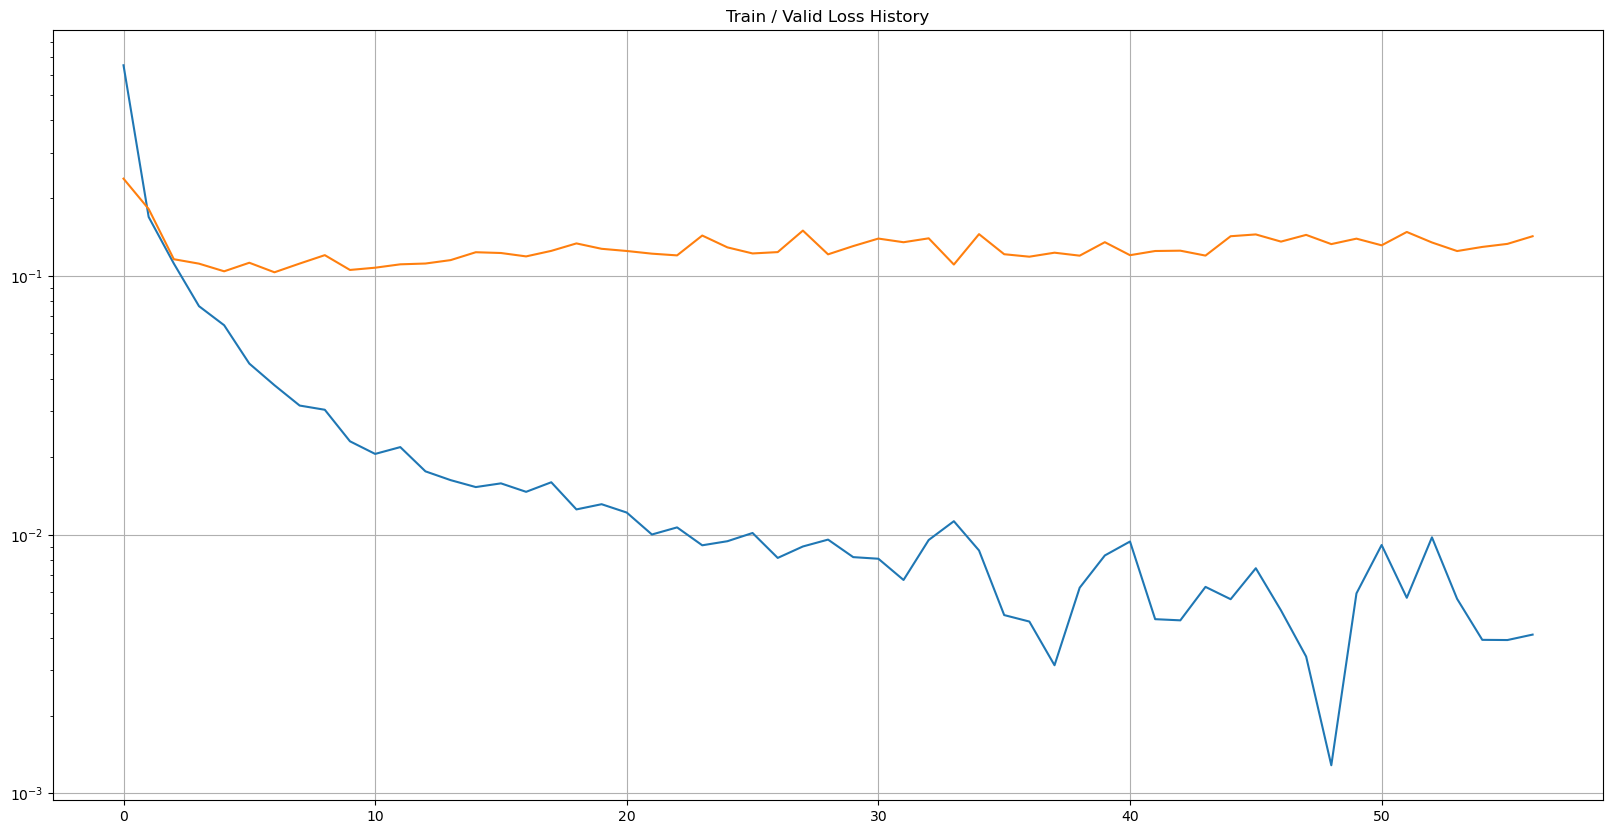

In [17]:
plot_from = 0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:]
)
plt.yscale('log')
plt.show()

In [18]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim =0)
    y_ = y[-1].split(batch_size, dim =0)

    for x_i,y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss

        y_hat += [y_hat_i]
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("test loss: %.4e" % test_loss)

test loss: 3.8096e-02


In [19]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Test Accuracy: %.4f" %(correct_cnt / total_cnt))

Test Accuracy: 0.9899


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [21]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' %i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)]
             )

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,5875,0,6,2,2,2,6,9,13,8
true_1,0,6716,3,4,3,0,2,7,5,2
true_2,6,10,5840,21,15,1,3,46,15,1
true_3,0,2,3,6089,0,15,0,9,9,4
true_4,0,8,2,0,5781,2,3,8,3,35
true_5,0,1,0,19,1,5368,9,1,17,5
true_6,6,6,1,0,19,12,5860,0,14,0
true_7,0,20,4,3,4,1,0,6223,2,8
true_8,2,13,6,22,4,6,0,2,5785,11
true_9,3,3,0,19,25,7,0,27,9,5856
